# Multi-vehicle Rendezvous Problem

The dynamics model of an omnidirectional vehicle with friction coefficient $\alpha$ is defined by the following equation:

$$
m \dot{\textbf{v}} = \textbf{u} - \alpha \textbf{v}
$$

PDDP is applied to a two vehicle system in order to control them to gently collide with each other with a terminal velocity of $0 \frac{m}{s}$.

The state vector $\textbf{x}$ is defined as follows: $$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x_0 & y_0 & x_1 & y_1 & \dot{x}_0 & \dot{y}_0 & \dot{x}_1 & \dot{y}_1
    \end{bmatrix}
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows: $$\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x_0} & F_{y_0} & F_{x_1} & F_{y_1}
    \end{bmatrix}
\end{equation*}$$

**Note**: That since this dynamics model is linear, this problem can be solved more efficiently with a simple Linear Quadratic Regulator (LQR) instead.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import numpy as np
import torch

In [22]:
N = 200  # Horizon length.
H = N*2
DT = 0.1  # Time step (s).
RENDER = True  # Whether to render the environment or not.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.rendezvous.RendezvousCost()
model = pddp.examples.rendezvous.RendezvousDynamicsModel(DT)
env = pddp.examples.rendezvous.RendezvousEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
   
    X = Z.detach().numpy()
    U = U.detach().numpy()

    x_0 = X[:, 0]
    y_0 = X[:, 1]
    x_1 = X[:, 2]
    y_1 = X[:, 3]
    x_0_dot = X[:, 4]
    y_0_dot = X[:, 5]
    x_1_dot = X[:, 6]
    y_1_dot = X[:, 7]

    plt.figure()
    plt.title("Trajectory of the two omnidirectional vehicles")
    plt.plot(x_0, y_0, "r")
    plt.plot(x_1, y_1, "b")
    plt.legend(["Vehicle 1", "Vehicle 2"])

    plt.figure()
    plt.plot(t, x_0, "r")
    plt.plot(t, x_1, "b")
    plt.xlabel("Time (s)")
    plt.ylabel("x (m)")
    plt.title("X positional paths")
    plt.legend(["Vehicle 1", "Vehicle 2"])

    plt.figure()
    plt.plot(t, y_0, "r")
    plt.plot(t, y_1, "b")
    plt.xlabel("Time (s)")
    plt.ylabel("y (m)")
    plt.title("Y positional paths")
    plt.legend(["Vehicle 1", "Vehicle 2"])
    
    plt.figure()
    plt.plot(t, x_0_dot, "r")
    plt.plot(t, x_1_dot, "b")
    plt.xlabel("Time (s)")
    plt.ylabel("x_dot (m)")
    plt.title("X velocity paths")
    plt.legend(["Vehicle 1", "Vehicle 2"])

    plt.figure()
    plt.plot(t, y_0_dot, "r")
    plt.plot(t, y_1_dot, "b")
    plt.xlabel("Time (s)")
    plt.ylabel("y_dot (m)")
    plt.title("Y velocity paths")
    plt.legend(["Vehicle 1", "Vehicle 2"])
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, state, Z, U, J_opt):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    final_state = Z[-1, :4].detach().numpy()
    print("iteration", iteration + 1, state, J_opt, final_state)

In [10]:
controller = pddp.controllers.iLQRController(env, model, cost)

In [11]:
U = torch.randn(N, model.action_size)

In [19]:
J_hist = []
env.reset()
controller.eval()
Z, U, state = controller.fit(U, encoding=ENCODING, n_iterations=50, tol=1e-4,
                             on_iteration=on_iteration)

iteration 1 iLQRState.ACCEPTED 45735.953 [ 1.5893928   0.7154174   1.1600751  -0.26624095]
iteration 2 iLQRState.ACCEPTED 45626.56 [ 2.3374474 -2.315831   2.3229327 -2.3558984]
iteration 3 iLQRState.ACCEPTED 45624.71 [ 2.4055977 -2.41274    2.4079792 -2.4022806]
iteration 4 iLQRState.ACCEPTED 45624.555 [ 2.4078112 -2.4078982  2.4053986 -2.4046044]
iteration 5 iLQRState.ACCEPTED 45624.484 [ 2.4045966 -2.4005058  2.40312   -2.4008067]
iteration 6 iLQRState.ACCEPTED 45624.473 [ 2.4056861 -2.39874    2.4023283 -2.4009142]
iteration 7 iLQRState.ACCEPTED 45624.47 [ 2.4054608 -2.3976984  2.4024496 -2.4005852]
iteration 8 iLQRState.ACCEPTED 45624.465 [ 2.4058414 -2.3972418  2.4022048 -2.4007027]
iteration 9 iLQRState.ACCEPTED 45624.465 [ 2.405833  -2.3971257  2.4022574 -2.4006653]
iteration 10 iLQRState.ACCEPTED 45624.47 [ 2.405842  -2.397097   2.4022539 -2.4006617]
iteration 11 iLQRState.ACCEPTED 45624.473 [ 2.4058828 -2.3970015  2.4022465 -2.4006548]
iteration 12 iLQRState.ACCEPTED 45624.473

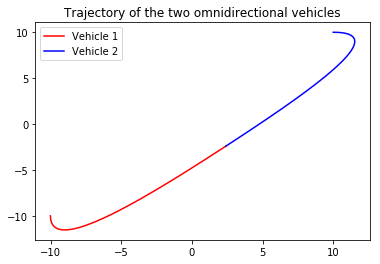

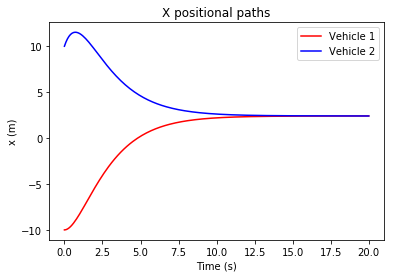

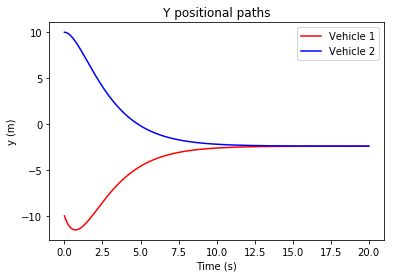

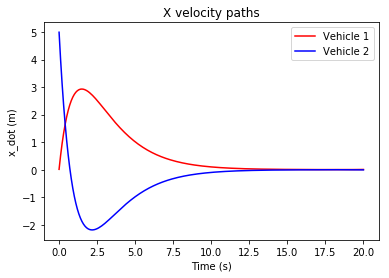

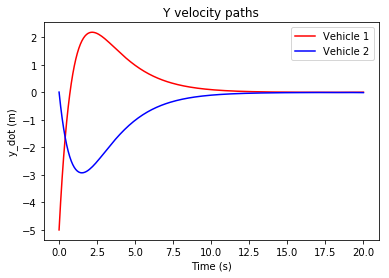

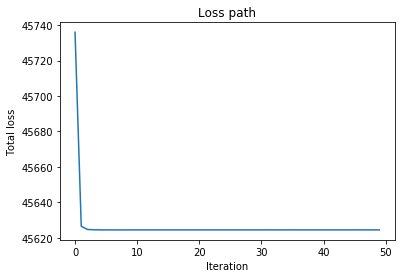

In [20]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [1]:
for u in U:
    env.apply(u)

NameError: name 'U' is not defined

In [16]:
env.close()